In [2]:
%load_ext autoreload
%autoreload 2
import mkl
mkl.set_num_threads(1)

48

In [3]:
import pickle
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns

plt = sns.mpl.pyplot
from aeff_calculations import calc_aeff_factor

from glob import glob
from scipy.interpolate import InterpolatedUnivariateSpline

from settings import LOCALPATH, BASEPATH
import settings as st
from tools import array_source_interp
from resolution import get_baseline_energy_res_kde

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Data release info
this is already "smoothed"

In [4]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)

In [5]:
all_E_grids, logE_bins_old, logE_reco_bins_old = get_baseline_energy_res_kde(
    renew_calc=False
)

calculating grids for energy KDE...


Text(0, 0.5, 'log10(E_reco/GeV)')

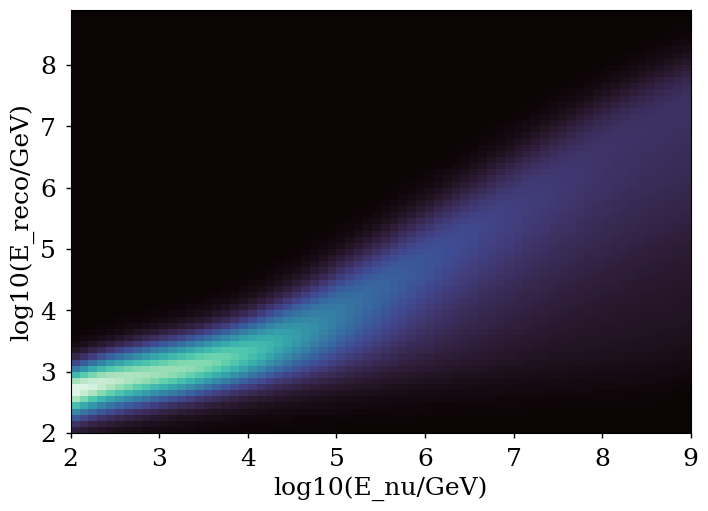

In [8]:
plt.pcolormesh(
    logE_bins_old, logE_reco_bins_old, all_E_grids["dec-0.0"]
)  # horizontal, for alerts. can use right dec per event, if necessary
plt.xlabel("log10(E_nu/GeV)")
plt.ylabel("log10(E_reco/GeV)")

idea: extend the e_reco PDF motivated by cross section?

Text(0.5, 0, 'log10(E_nu/GeV)')

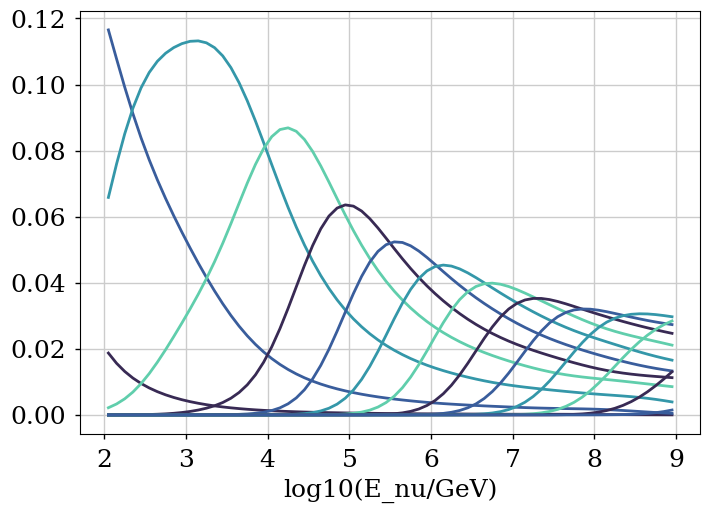

In [16]:
plt.plot(
    st.get_mids(logE_bins_old), all_E_grids["dec-0.0"][::5].T
)  # horizontal, for alerts. can use right dec per event, if necessary
plt.xlabel("log10(E_nu/GeV)")

### Xavier's models

(just as an example here)

In [14]:
import astropy.units as u
from astropy.constants import h
E = 1 * u.erg
nu = 1 * u.Hz
Enu = nu * h

# unit conversion
erg_to_GeV = E.to(u.GeV).value
nu_to_GeV = Enu.to(u.GeV).value
nu_to_erg = Enu.to(u.erg).value

In [48]:
# J2000 coordinates are RA = 15:04:24.98, Dec = +10:29:39.2
# " If you’re looking for “J2000” coordinates, and aren’t sure if you want to use this or FK5, you probably want to use ICRS.  " :)
flare_files = glob(join(st.LOCALPATH, "neutrino_models/*neutrino*.csv"))
# for the legend because I am lazy
style = {
    "proton-synchrotron": dict(label="proton-synchrotron", color="darkred", ls="-"),
    "ext_field_a": dict(label="ext_field_a", color="tab:blue", ls=":"),
    "lepto-hadronic": dict(label="lepto-hadronic", color="tab:orange", ls="--"),
}

Text(0.5, 0, 'E/GeV')

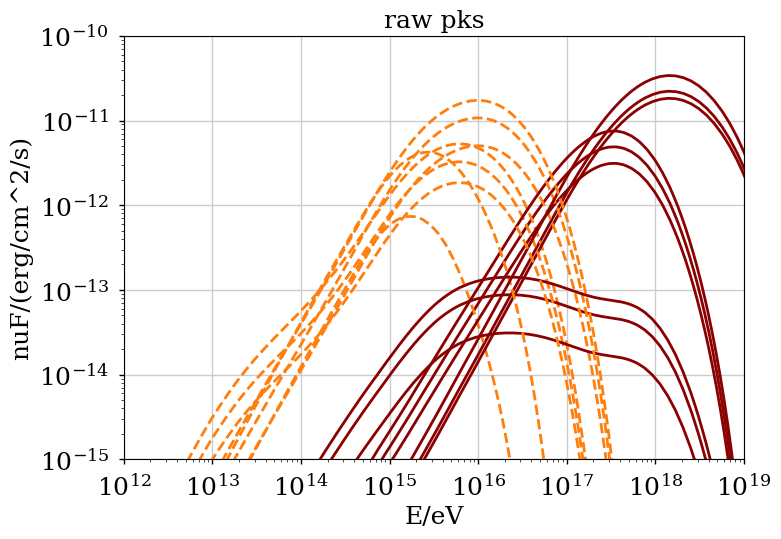

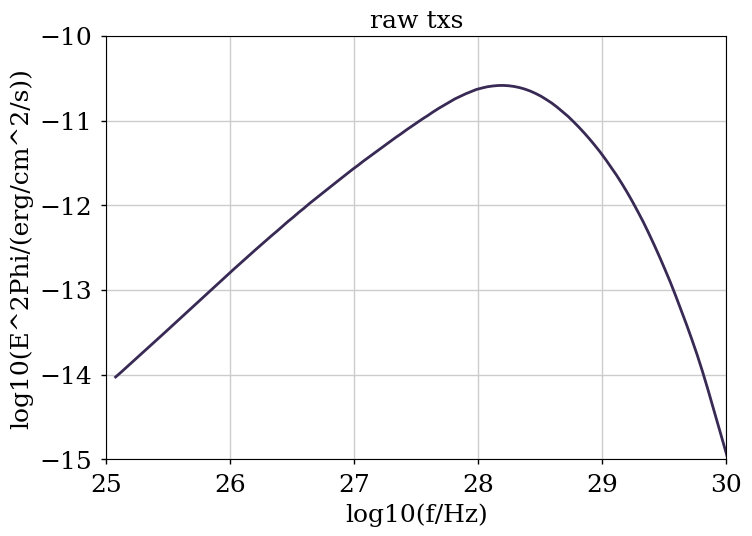

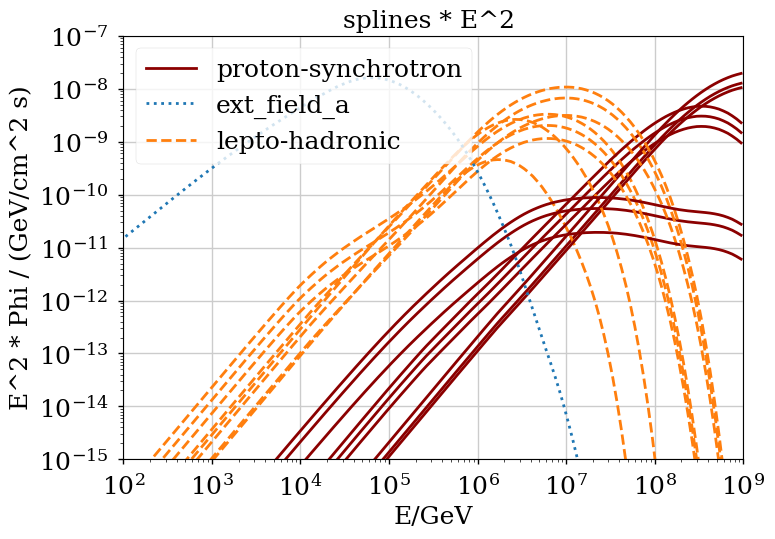

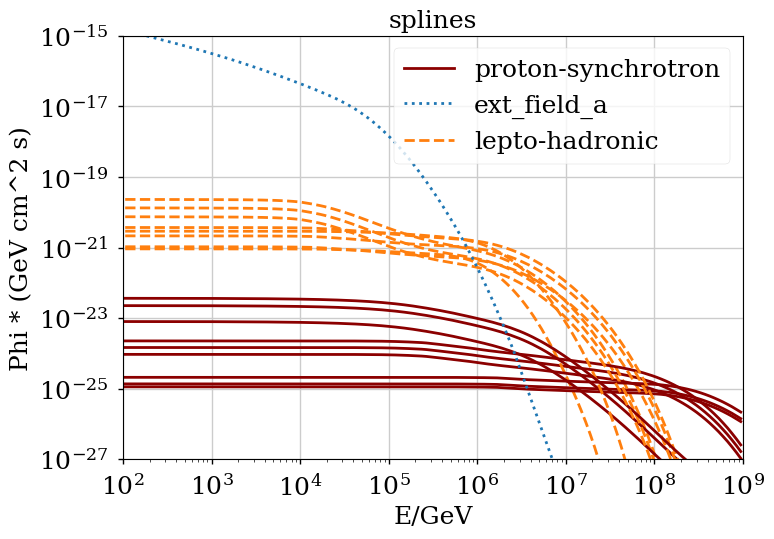

In [49]:
# just copied because I am lazy
tmp = []
plt.figure(1)
plt.title("raw pks")
plt.loglog()
plt.ylim(1e-15, 1e-10)
plt.xlim(1e12, 1e19)

plt.figure(3)
plt.title("splines * E^2 ")

plt.figure(4)
plt.title("splines")

for f in flare_files:
    # print(f)
    if "PSYN" in f:
        model = "proton-synchrotron"
    elif "txs" in f:
        model = "ext_field_a"
    else:
        model = "lepto-hadronic"

    if "pks_quiescent_neutrinos_bandmin" in f:
        # all zeros
        continue
    mapping = (
        {0: "E/eV", 1: "nuF/(erg/cm^2/s)"}
        if "pks" in f
        else {0: "log10(f/Hz)", 1: "log10(E^2Phi/(erg/cm^2/s))"}
    )
    dat = pd.read_csv(f, header=None).T.rename(columns=mapping)
    labels = f.split("/")[-1].split(".")[0].split("_")

    if "pks" in f:
        mask = dat["nuF/(erg/cm^2/s)"] > 0  # 1e-30
        x = np.log10(dat["E/eV"].loc[mask] / 1e9)  # eV -> GeV
        y = (
            np.log10(dat["nuF/(erg/cm^2/s)"].loc[mask] * erg_to_GeV) - 2 * x
        )  #  nu F_nu -> dN/dt dE dA
        mask = np.isfinite(x) & np.isfinite(y)
        model_spline = InterpolatedUnivariateSpline(x[mask], y[mask], k=1)
        plt.figure(1)
        ax = sns.lineplot(
            data=dat,
            x="E/eV",
            y="nuF/(erg/cm^2/s)",
            color=style[model]["color"],
            ls=style[model]["ls"],
        )

    elif "txs" in f:
        mask = dat["log10(E^2Phi/(erg/cm^2/s))"] > -100  # -30
        x = dat["log10(f/Hz)"].loc[mask] + np.log10(nu_to_GeV)  # nu -> GeV
        y = (
            dat["log10(E^2Phi/(erg/cm^2/s))"].loc[mask] + np.log10(erg_to_GeV) - 2 * x
        )  #  E² Phi [erg] -> Phi [GeV]
        mask = np.isfinite(x) & np.isfinite(y)
        model_spline = InterpolatedUnivariateSpline(x[mask], y[mask], k=1)

        plt.figure(2)
        plt.title("raw txs")
        ax = sns.lineplot(data=dat, x="log10(f/Hz)", y="log10(E^2Phi/(erg/cm^2/s))")
        ax.set_ylim(-15, -10)
        ax.set_xlim(25, 30)

    else:
        print("???")

    plt.figure(3)
    plt.plot(
        10**st.logE_mids,
        10 ** (model_spline(st.logE_mids) + 2 * st.logE_mids),
        color=style[model]["color"],
        ls=style[model]["ls"],
    )
    plt.figure(4)
    plt.plot(
        10**st.logE_mids,
        10 ** model_spline(st.logE_mids),
        color=style[model]["color"],
        ls=style[model]["ls"],
    )

    tmp.append(
        {
            "src_name": labels[0],
            "model_name": model,
            "state": labels[-3],
            "bf_or_band": labels[-1],
            "model_spline": model_spline,
            "N_nu(IC)": 0,
            "dec/rad": 0,
            "livetime/s": 0,
        }
    )

plt.figure(3)
for k in style:
    plt.plot(0, 0, **style[k])
plt.legend()
plt.loglog()
plt.xlim(1e2, 1e9)
plt.ylim(1e-15, 1e-7)
plt.ylabel("E^2 * Phi / (GeV/cm^2 s)")
plt.xlabel("E/GeV")

plt.figure(4)
for k in style:
    plt.plot(0, 0, **style[k])
plt.legend()
plt.loglog()
plt.xlim(1e2, 1e9)
plt.ylim(1e-27, 1e-15)
plt.ylabel("Phi * (GeV cm^2 s)")
plt.xlabel("E/GeV")

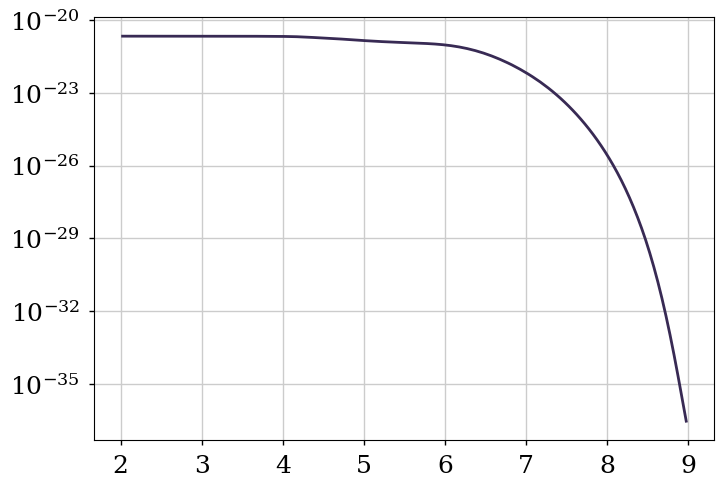

In [54]:
xr_models = pd.DataFrame(tmp)
# xr_models.loc[(xr_models.src_name=="pks") & (xr_models.bf_or_band == "bestfit")]

exemplary_model = xr_models.iloc[12]
exemplary_model
plt.plot(
    st.logE_mids,
    10 ** exemplary_model.model_spline(st.logE_mids),
)
plt.yscale("log")